In [1]:
#Change directory to data location
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
#Import package
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from tqdm import tqdm
import seaborn as sns
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

In [4]:
selectst=['96745', '96741', '96747', '96733', '96749']

In [5]:
datast=pd.read_excel('E:\Data stasiun BMKG\A-Database.xlsx', index_col=2)
datast.index = datast.index.astype(str)
datastslc=datast.loc[selectst]

In [15]:
#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')

In [16]:
#Date event CENS CS no CS (1-->CS, 0-->no CS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = censevt[censevt['cs event'] == i].index
    print("Banyak kejadian CENS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(censevt)))
    print("Banyak kejadian CENS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(censevt.index))))
    evt_cens_cs.append(evt_cens.values)

Banyak kejadian CENS 0 = 48 dari 117
Banyak kejadian CENS 0 = 41.02564102564103%
Banyak kejadian CENS 1 = 69 dari 117
Banyak kejadian CENS 1 = 58.97435897435897%


In [17]:
evt_cens_cs=[evt_cens_cs[1], evt_cens_cs[0]]

In [9]:
chstmeancs=np.empty([len(evt_cens_cs[0])], dtype=float)
chstmeancsstd=np.empty([len(evt_cens_cs[0])], dtype=float)

for evt in tqdm(range(len(evt_cens_cs[0]))):
    chst=np.empty([len(datastslc)])
    anomchst=np.empty([len(datastslc)])
    for i in range(len(datastslc)):
        data=pd.read_csv('E:/Data stasiun BMKG/Reformat daily/' + datastslc.index[i] +'.csv')
        data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d')
        data['RR(mm/dy)'] = pd.to_numeric(data['RR(mm/dy)'], errors='coerce')
        data = data.set_index('Date',drop=False)
        data = data.loc['2001-11-01':'2020-03-31']
        tglcens = np.array([evt_cens_cs[0][evt], evt_cens_cs[0][evt]+np.timedelta64(1,'D')])
        chst[i] = data['RR(mm/dy)'].loc[tglcens[np.isin(tglcens,data['Date'])]].max()
        season = ((data.index.month % 12 + 3) // 3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})
        klimdjf = data[season == 'DJF']['RR(mm/dy)'].mean()
        anomchst[i] = chst[i] - klimdjf
    chstmeancs[evt]=np.nanmean(chst)
    chstmeancsstd[evt]=np.nanstd(chst)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:21<00:00,  3.20it/s]


In [10]:
chcs=pd.DataFrame({'tglcens': evt_cens_cs[0],
                   'chmean':chstmeancs,
                   'chstd':chstmeancsstd
                          })
chcs=chcs.set_index('tglcens')

In [11]:
chstmeanncs=np.empty([len(evt_cens_cs[1])], dtype=float)
chstmeanncsstd=np.empty([len(evt_cens_cs[1])], dtype=float)

for evt in tqdm(range(len(evt_cens_cs[1]))):
    chst=np.empty([len(datastslc)])
    anomchst=np.empty([len(datastslc)])
    for i in range(len(datastslc)):
        data=pd.read_csv('E:/Data stasiun BMKG/Reformat daily/' + datastslc.index[i] +'.csv')
        data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d')
        data['RR(mm/dy)'] = pd.to_numeric(data['RR(mm/dy)'], errors='coerce')
        data = data.set_index('Date',drop=False)
        data = data.loc['2001-11-01':'2020-03-31']
        tglcens = np.array([evt_cens_cs[1][evt], evt_cens_cs[1][evt]+np.timedelta64(1,'D')])
        chst[i] = data['RR(mm/dy)'].loc[tglcens[np.isin(tglcens,data['Date'])]].max()
        season = ((data.index.month % 12 + 3) // 3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})
        klimdjf = data[season == 'DJF']['RR(mm/dy)'].mean()
        anomchst[i] = chst[i] - klimdjf
    chstmeanncs[evt]=np.nanmean(chst)
    chstmeanncsstd[evt]=np.nanstd(chst)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.08it/s]


In [12]:
chncs=pd.DataFrame({'tglcens': evt_cens_cs[1],
                   'chmean':chstmeanncs,
                   'chstd':chstmeanncsstd
                          })
chncs=chncs.set_index('tglcens')

In [18]:
#Read Banjir excel data
floodevt=pd.read_excel('data\Data Banjir Jakarta.xlsx')
floodevt['tanggal']= pd.to_datetime(floodevt['tanggal'], format='%Y-%m-%d')
floodevt=floodevt.set_index('tanggal')
floodevt = floodevt.groupby(floodevt.index.floor('D')).sum()

In [19]:
floodevtcens=np.empty(2)
tglcsf=[]
tglncsf=[]
tglcsfd=[]
tglncsfd=[]
bacsf=[]
bancsf=[]
krbcs=[]
krbncs=[]
chcsv=[]
chncsv=[]
chcss=[]
chncss=[]
idxcsv=[]
idxncsv=[]
durcsv=[]
durncsv=[]
for i in range(2):
    totalbanjir=0
    korban=0
    for f in tqdm(range(len(evt_cens_cs[i]))):
        datacens=censevt.loc[evt_cens_cs[i][f]]
        rangecens=pd.date_range(datacens['time_start'], datacens['time_start']+np.timedelta64(datacens['duration']-1,'D'))
        for t in rangecens:
            for e in floodevt.index.values:
                e=[e]
                if (t in e) or (t+np.timedelta64(1,'D') in e) or (t+np.timedelta64(2,'D') in e) or (t+np.timedelta64(-1,'D') in e) or (t+np.timedelta64(-2,'D') in e):
                    totalbanjir=totalbanjir+1
                    if i==0:
                        tglcsf.append(evt_cens_cs[i][f])
                        tglcsfd.append(e[0])
                        bacsf.append((evt_cens_cs[i][f]<=e[0])*1)
                        krbcs.append(floodevt.loc[e[0]]['korban_total'])
                        chcsv.append(chcs.loc[evt_cens_cs[i][f]]['chmean'])
                        chcss.append(chcs.loc[evt_cens_cs[i][f]]['chstd'])
                        idxcsv.append(censevt.loc[evt_cens_cs[i][f]]['maxmagnitude'])
                        durcsv.append(censevt.loc[evt_cens_cs[i][f]]['duration'])
                    elif i==1:
                        tglncsf.append(evt_cens_cs[i][f])
                        tglncsfd.append(e[0])
                        bancsf.append((evt_cens_cs[i][f]<=e[0])*1)
                        krbncs.append(floodevt.loc[e[0]]['korban_total'])
                        chncsv.append(chncs.loc[evt_cens_cs[i][f]]['chmean'])
                        chncss.append(chncs.loc[evt_cens_cs[i][f]]['chstd'])
                        idxncsv.append(censevt.loc[evt_cens_cs[i][f]]['maxmagnitude'])
                        durncsv.append(censevt.loc[evt_cens_cs[i][f]]['duration'])
    floodevtcens[i]=totalbanjir

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 15.09it/s]


In [20]:
fdcs=pd.DataFrame({'tglcens': tglcsf,
                   'tglfld':tglcsfd,
                   'korban':krbcs,
                    'c'  :bacsf,
                          })
fdcs=fdcs.set_index('tglcens')
fdcs=fdcs.groupby(fdcs.index.floor('D')).max()

In [21]:
fdncs=pd.DataFrame({'tglcens': tglncsf,
                    'tglfld':tglncsfd,
                    'korban':krbncs,
                    'c'  :bancsf,
                          })
fdncs=fdncs.set_index('tglcens')
fdncs=fdncs.groupby(fdncs.index.floor('D')).max()

In [22]:
tglfldcs=fdcs.index.values
chstmeancsfd=np.empty([len(tglfldcs)], dtype=float)
for evt in tqdm(range(len(tglfldcs))):
    chst=np.empty([len(datastslc)])
    anomchst=np.empty([len(datastslc)])
    for i in range(len(datastslc)):
        data=pd.read_csv('E:\Data stasiun BMKG\Reformat daily/' + datastslc.index[i] +'.csv')
        data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d')
        data['RR(mm/dy)'] = pd.to_numeric(data['RR(mm/dy)'], errors='coerce')
        data = data.set_index('Date',drop=False)
        data = data.loc['2001-11-01':'2020-03-31']
        tglcens = np.array([tglfldcs[evt], tglfldcs[evt]+np.timedelta64(1,'D')])
        chst[i] = data['RR(mm/dy)'].loc[tglcens[np.isin(tglcens,data['Date'])]].max()
    chstmeancsfd[evt]=np.nanmean(chst)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.34it/s]


In [23]:
tglfldncs=fdncs.index.values
chstmeanncsfd=np.empty([len(tglfldncs)], dtype=float)
for evt in tqdm(range(len(tglfldncs))):
    chst=np.empty([len(datastslc)])
    for i in range(len(datastslc)):
        data=pd.read_csv('E:\Data stasiun BMKG\Reformat daily/' + datastslc.index[i] +'.csv')
        data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d')
        data['RR(mm/dy)'] = pd.to_numeric(data['RR(mm/dy)'], errors='coerce')
        data = data.set_index('Date',drop=False)
        data = data.loc['2001-11-01':'2020-03-31']
        tglcens = np.array([tglfldncs[evt], tglfldncs[evt]+np.timedelta64(1,'D')])
        chst[i] = data['RR(mm/dy)'].loc[tglcens[np.isin(tglcens,data['Date'])]].max()
    chstmeanncsfd[evt]=np.nanmean(chst)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.36it/s]


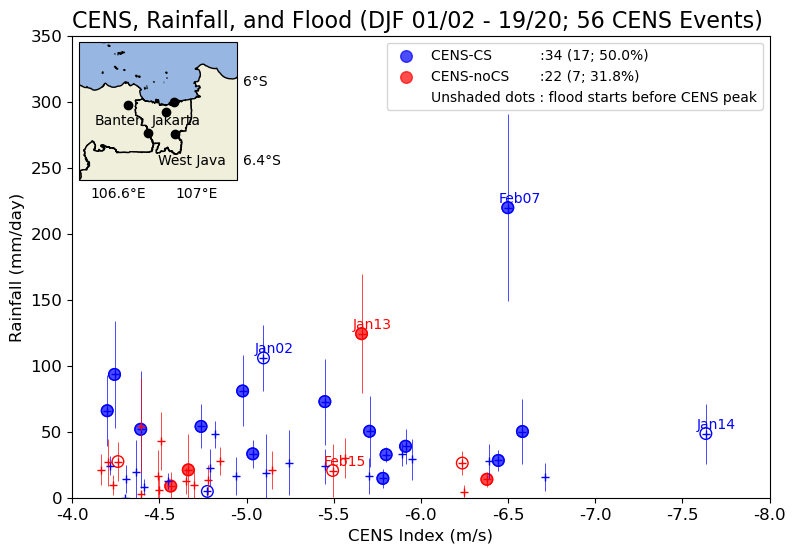

In [24]:
fig, ax1 = plt.subplots()
fig.set_size_inches([9,6])

datasetcs=censevt.loc[evt_cens_cs[0]]
datasetncs=censevt.loc[evt_cens_cs[1]]
ax1.errorbar(datasetcs['maxmagnitude'].values, chstmeancs, yerr=chstmeancsstd, c='b', linestyle='None', linewidth=0.5, marker='+')
ax1.errorbar(datasetncs['maxmagnitude'].values, chstmeanncs, yerr=chstmeanncsstd, c='r', linestyle='None', linewidth=0.5, marker='+')

datafdcs=censevt.loc[tglfldcs]
datafdncs=censevt.loc[tglfldncs]
ax1.scatter(datafdcs['maxmagnitude'].values, chstmeancsfd, s=70, facecolors='none', edgecolors='b')
ax1.scatter(datafdncs['maxmagnitude'].values, chstmeanncsfd, s=70,  facecolors='none', edgecolors='r')
ax1.scatter(datafdcs['maxmagnitude'].values, chstmeancsfd, c='b', s=70, alpha=fdcs['c'].values*0.7)
ax1.scatter(datafdncs['maxmagnitude'].values, chstmeanncsfd, c='r', s=70, alpha=fdncs['c'].values*0.7)
ax1.scatter([], [], c='b', s=70, alpha=0.7, label='CENS-CS           :' +str(np.sum(np.isfinite(chstmeancs)*1))+' (' +str(len(tglfldcs))+'; '+str(np.round(len(tglfldcs)/(np.sum(np.isfinite(chstmeancs)*1))*100,1))+'%'+')')
ax1.scatter([], [], c='r', s=70, alpha=0.7, label='CENS-noCS       :' +str(np.sum(np.isfinite(chstmeanncs)*1))+ ' ('+str(len(tglfldncs))+'; '+str(np.round((len(tglfldncs))/(np.sum(np.isfinite(chstmeanncs)*1))*100,1))+'%'+')')

ax1.plot([],[], alpha=0, label='Unshaded dots : flood starts before CENS peak')

ax1.text(datafdcs['maxmagnitude'].values[0]+0.05, chstmeancsfd[0]+4, 'Jan02', c='b')
ax1.text(datafdcs['maxmagnitude'].values[3]+0.05, chstmeancsfd[3]+4, 'Feb07', c='b')
ax1.text(datafdcs['maxmagnitude'].values[7]+0.05, chstmeancsfd[7]+4, 'Jan14', c='b')
ax1.text(datafdncs['maxmagnitude'].values[4]+0.05, chstmeanncsfd[4]+4, 'Jan13', c='r')
ax1.text(datafdncs['maxmagnitude'].values[5]+0.05, chstmeanncsfd[5]+4, 'Feb15', c='r')

ax1.set_xlim([-4, -8])
ax1.set_ylim([0, 350])
ax1.set_xticks(np.arange(-4,-8.1,-0.5))
ax1.set_xticklabels(np.arange(-4,-8.1,-0.5), fontsize=12)
ax1.set_yticks(np.arange(0,351,50))
ax1.set_yticklabels(np.arange(0,351,50), fontsize=12)
ax1.set_xlabel('CENS Index (m/s)',fontsize=12)
ax1.set_ylabel('Rainfall (mm/day)',fontsize=12)
ax1.set_title('CENS, Rainfall, and Flood (DJF 01/02 - 19/20; ' +str(np.sum(np.isfinite(chstmeancs)*1)+np.sum(np.isfinite(chstmeanncs)*1))+' CENS Events)', fontsize=16, loc='left')

ax1.legend(loc='upper right')

left, bottom, width, height = [0.105, 0.64, 0.23, 0.23]
ax = fig.add_axes([left, bottom, width, height],projection=ccrs.PlateCarree())
ax.set_extent([106.4, 107.2, -6.5, -5.8])
gl=ax.gridlines(draw_labels=True,linewidth=0)
gl.xlocator = tk.FixedLocator([106.6, 107])
gl.ylocator = tk.FixedLocator([-6.4, -6])
gl.top_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.imshow(np.tile(np.array([[[151, 182, 225]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=[106.4, 107.2, -6.5, -5.8])
shape_feature = ShapelyFeature(Reader('E:/Data/gadm40_IDN_shp/gadm40_IDN_1.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='#efefdb', edgecolor='black',)
ax.add_feature(shape_feature)
ax.scatter(datastslc['Bujur'], datastslc['Lintang'], color='k', zorder=3)

plt.text(106.77, -6.22, 'Jakarta', fontsize=10)
plt.text(106.48, -6.22, 'Banten', fontsize=10)
plt.text(106.8, -6.42, 'West Java', fontsize=10)
plt.savefig('figure_output\Fig 12.pdf', bbox_inches='tight')
plt.show()